In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import expon,uniform,randint

from sklearn import linear_model
from sklearn.model_selection import train_test_split,RandomizedSearchCV,validation_curve
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

from sklearn import tree
from graphviz import Source
from IPython.display import SVG

#Display all columns on iPython Notebook
pd.options.display.max_columns = None

#Create the main data frame
#In production code this needs to be relative paths
employee_data = pd.read_csv('EmployeeAttrition.csv')


In [2]:
employee_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [3]:
employee_data.info()
#All are non nulls of the same number of entries, no imputation required

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EmployeeCount               1470 non-null int64
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome         

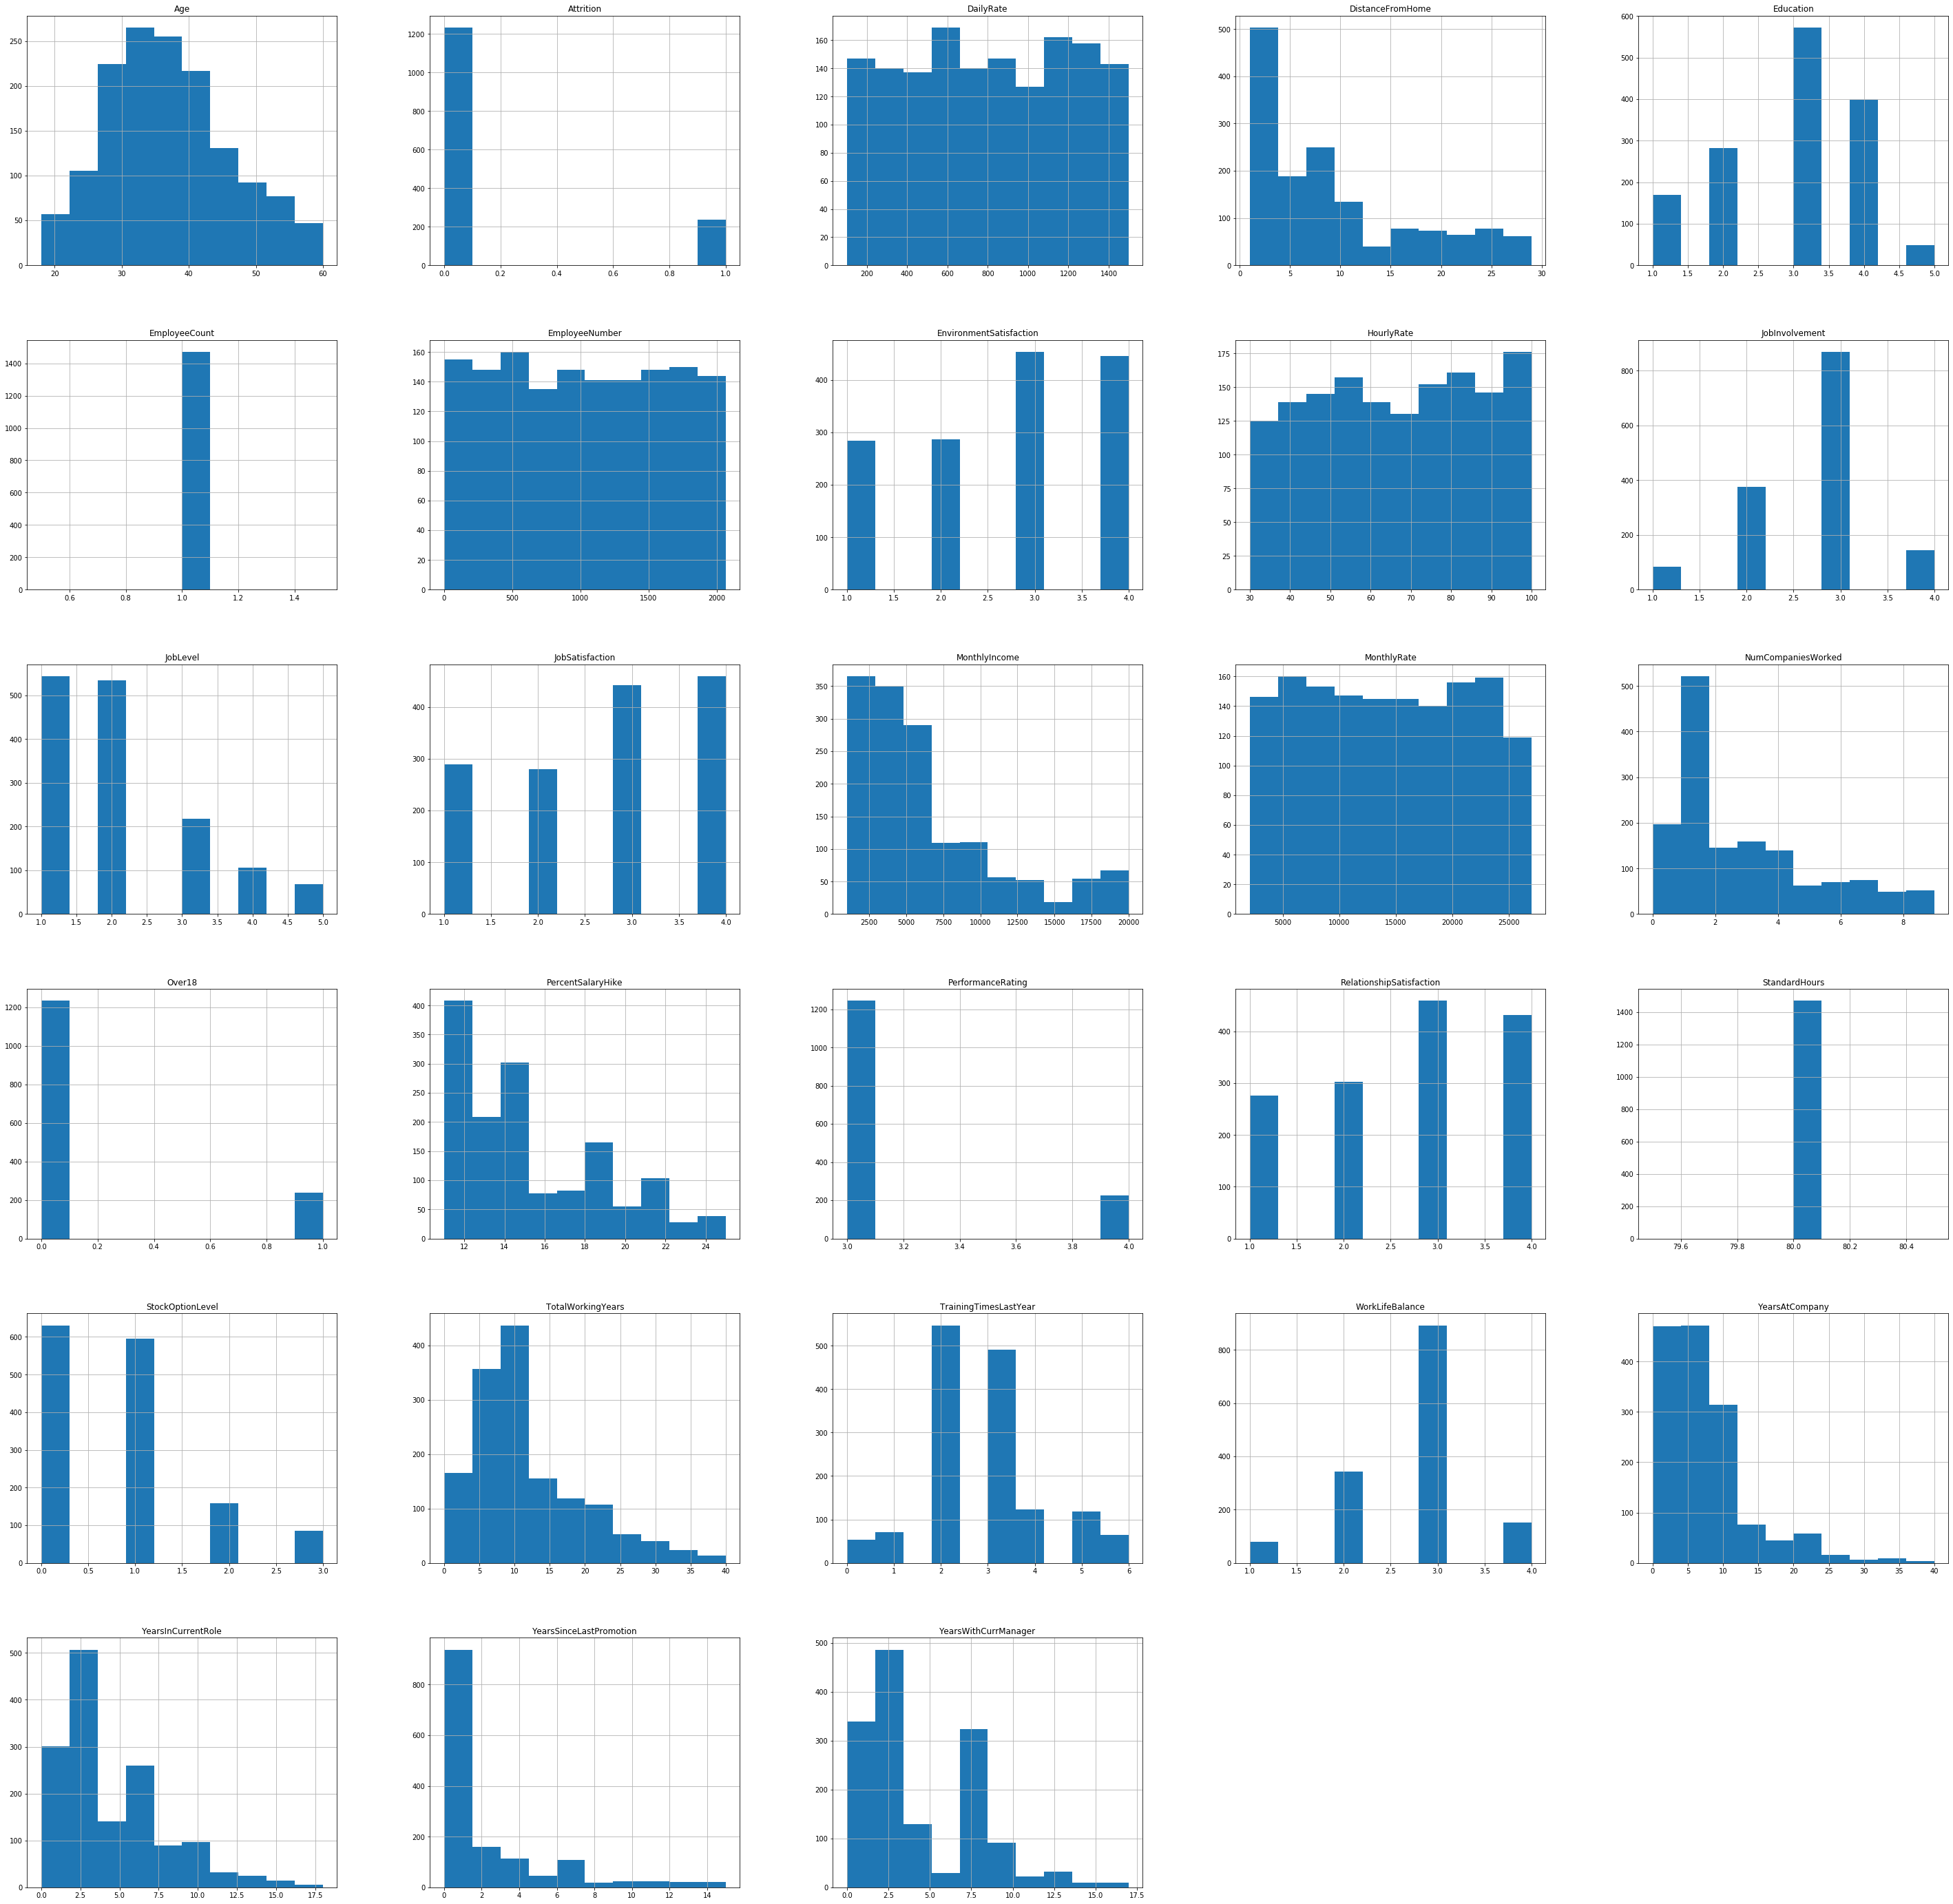

In [4]:
employee_data['Attrition'] = employee_data.Attrition.astype("category").cat.codes
employee_data['Over18'] = employee_data.Attrition.astype("category").cat.codes

employee_data.hist(figsize=(50, 50));

#Notes
#Data Right Skewed - MonthlyIncome DistanceFromHome, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion etc.,
#So transformation might be required (for non-parametric models) prior to fitting a model
#Attrition - Our target variable is highly imbalanced as seen below

In [5]:
#Employee Number, EmployeeCount, StandardHours are redundant as they are constants, we will drop these
#Also Over18 as we would see later has a correlation of 1.0 with Attrition, can be safely removed
employee_data=employee_data.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis="columns")

In [6]:
#Printing the column (numeric/categorical) column names for later use
cols = employee_data.columns

numeric_cols = employee_data._get_numeric_data().columns
print("Numeric Columns: ", numeric_cols, "\n")

categorical_columns = list(set(cols) - set(numeric_cols))
print("Categorical Columns: ", categorical_columns)

Numeric Columns:  Index(['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object') 

Categorical Columns:  ['OverTime', 'Department', 'EducationField', 'MaritalStatus', 'BusinessTravel', 'JobRole', 'Gender']


In [7]:
employee_data.describe()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,0.161224,802.485714,9.192517,2.912925,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,0.367863,403.509100,8.106864,1.024165,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,0.000000,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,465.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,0.000000,802.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,0.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [8]:
#Utility function to display bar charts
def display_bars(cat):
    col_iter = 1
    for cat_column_label in cat:
        plt.subplot(3,3,col_iter)
        bar_plot = sns.barplot(x=f"{cat_column_label}", y='Attrition', data=employee_data)
        bar_plot.set_xticklabels(bar_plot.get_xticklabels(),rotation=20)
        plt.ylabel('Attrition')
        plt.xlabel(f'{cat_column_label}')
        col_iter += 1

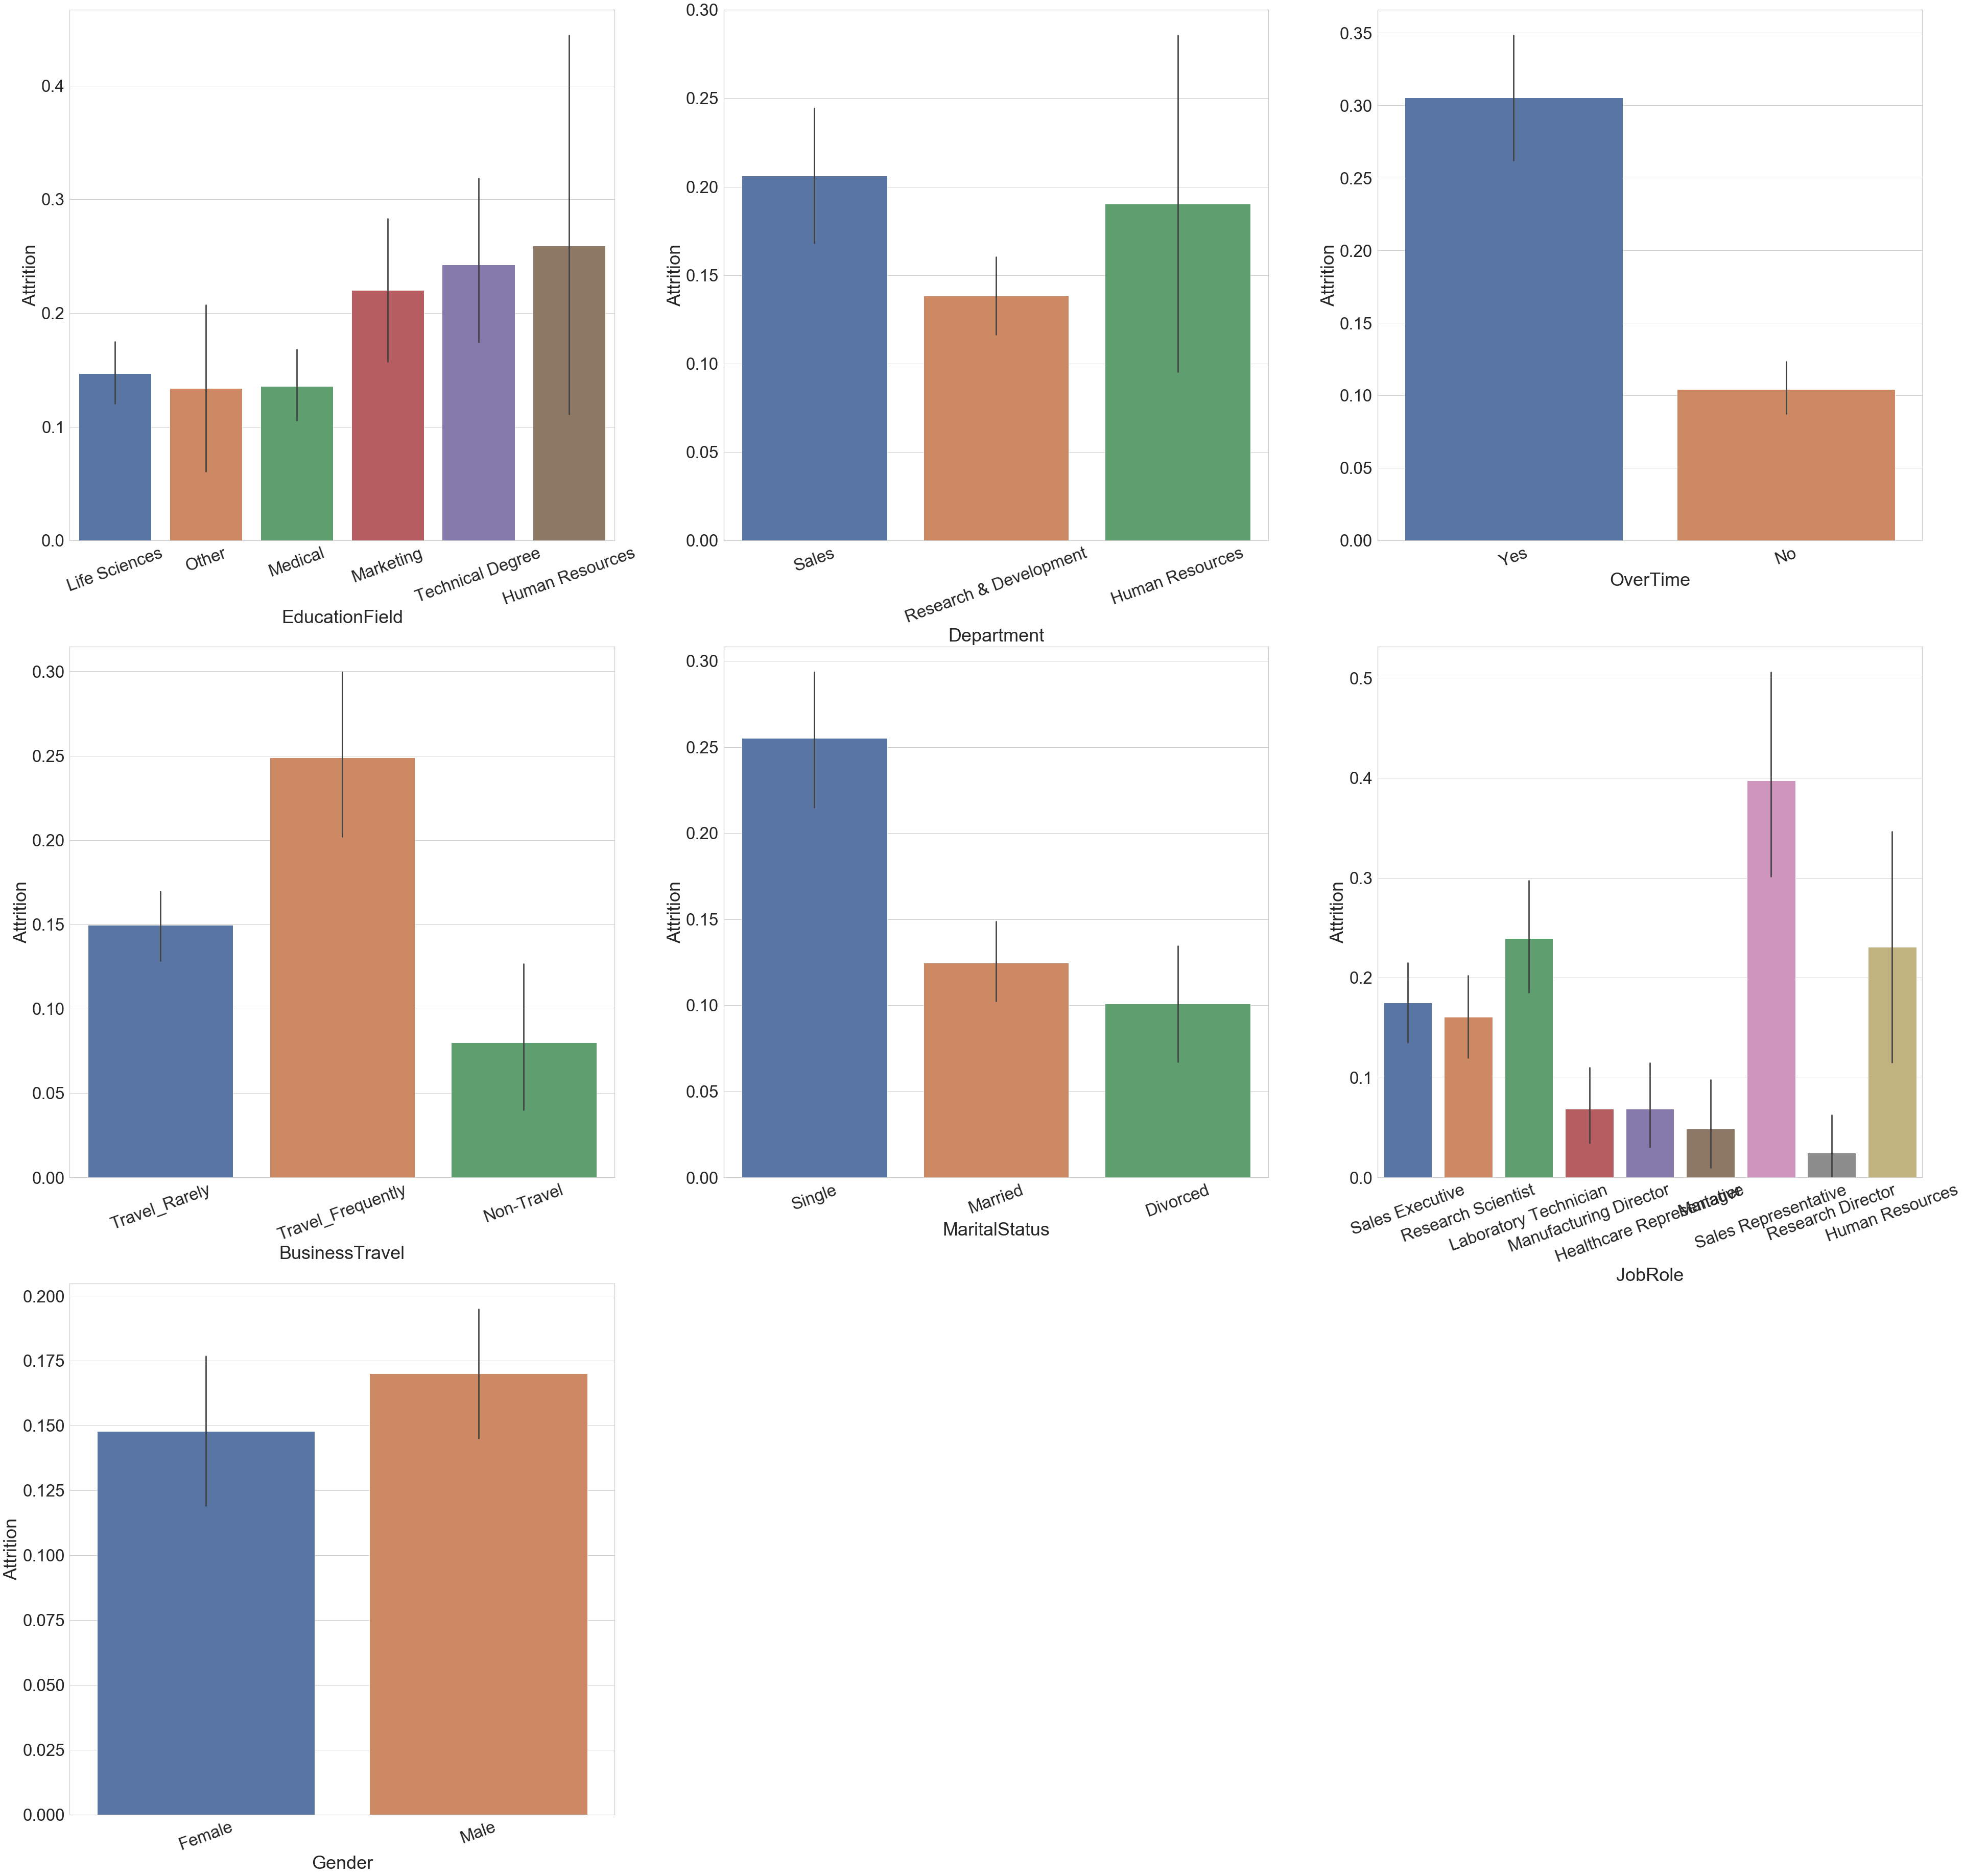

In [9]:
#Citation: https://stackoverflow.com/questions/42103348/how-to-improve-spacing-of-labels-on-seaborn-axis
categorical = ['EducationField', 'Department', 'OverTime', 'BusinessTravel', 
               'MaritalStatus', 'JobRole', 'Gender']
sns.set(font_scale=3.0,palette="deep")
sns.set_style("whitegrid")
plt.figure(figsize=(65, 65))
display_bars(categorical)


#Research & Development employees are relatively happier
#Attrition high for people who travel frequently, work overtime, are singles
#Attrition very high for sales representatives
#Directors+ are more satisfied with jobs

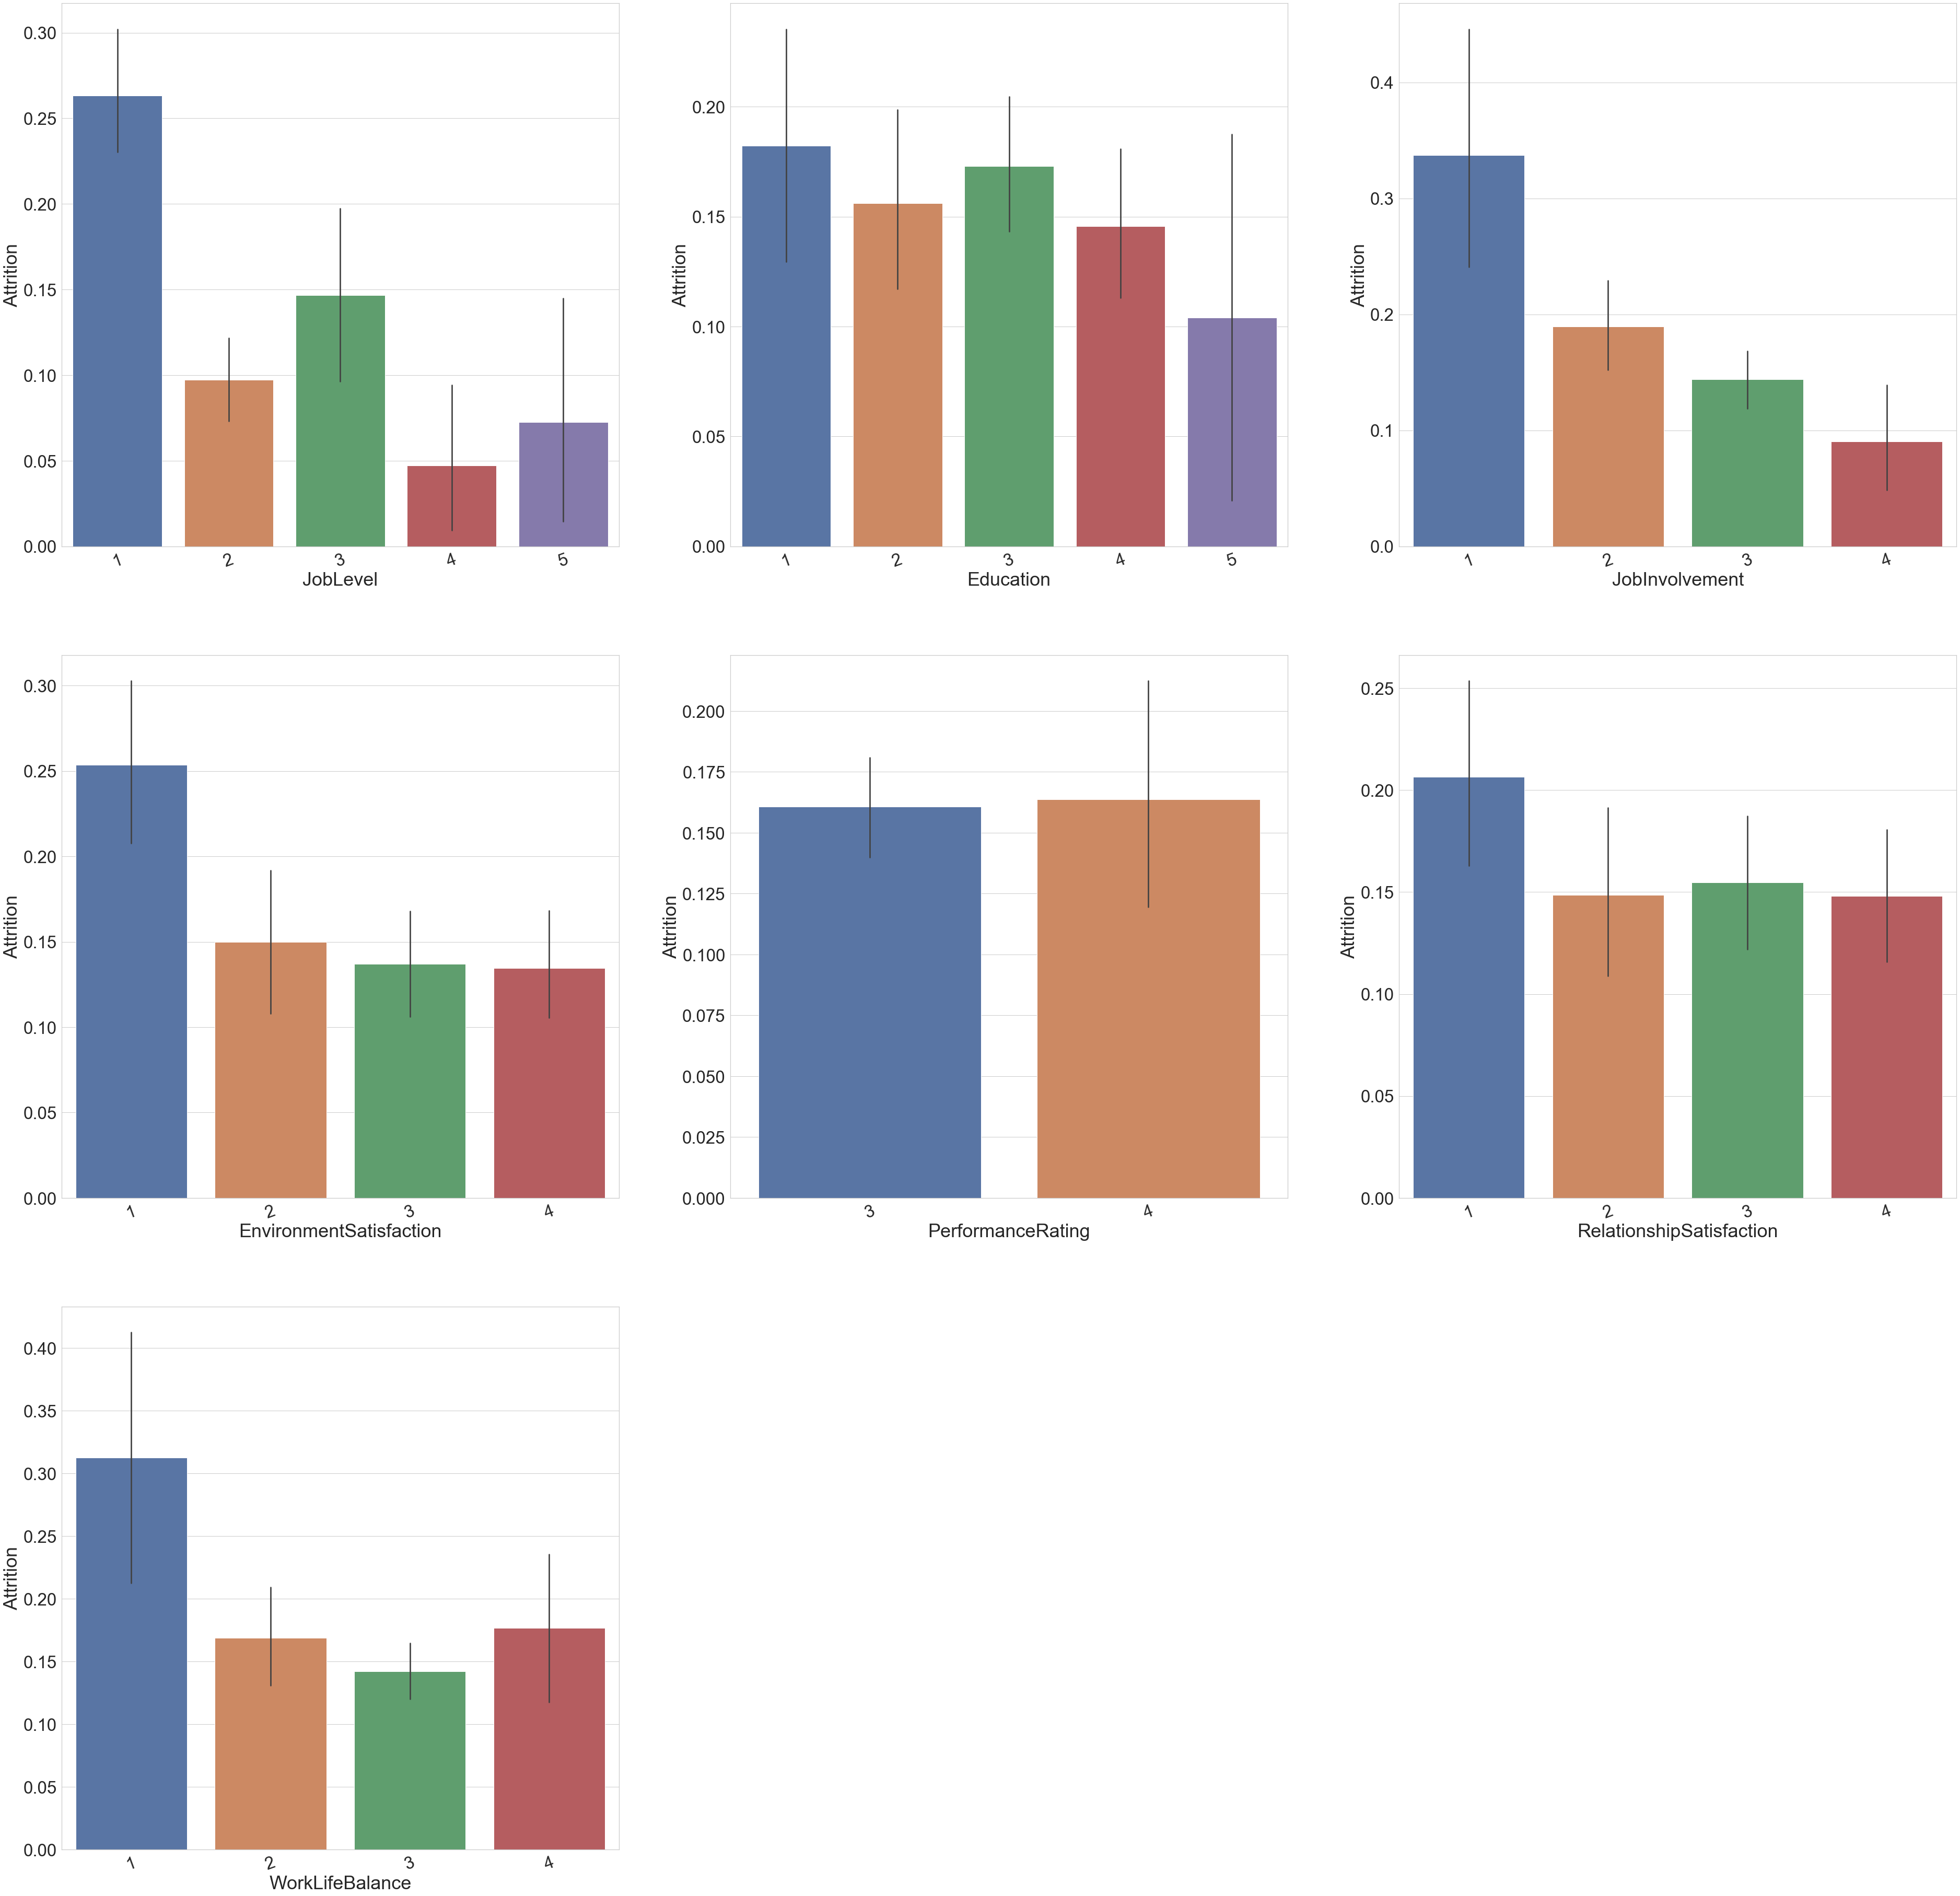

In [10]:
sns.set(font_scale=3.0,palette="deep")
sns.set_style("whitegrid")
plt.figure(figsize=(65, 65))

other_categories = ['JobLevel','Education','JobInvolvement','EnvironmentSatisfaction',
                    'PerformanceRating','RelationshipSatisfaction','WorkLifeBalance']
display_bars(other_categories)

#Notes
#Job Level 1 (Might be junior employees) has high Attrition rates
#Senior Roles (?) Job Level 4 and 5 seems to be more stable
#The less the job involvement or empowerment (?) or belongingness leads to high attrition
#Performance Rating has no effect
#Comnsidering 1 being indicative of a Low work life balance, people tend to leave

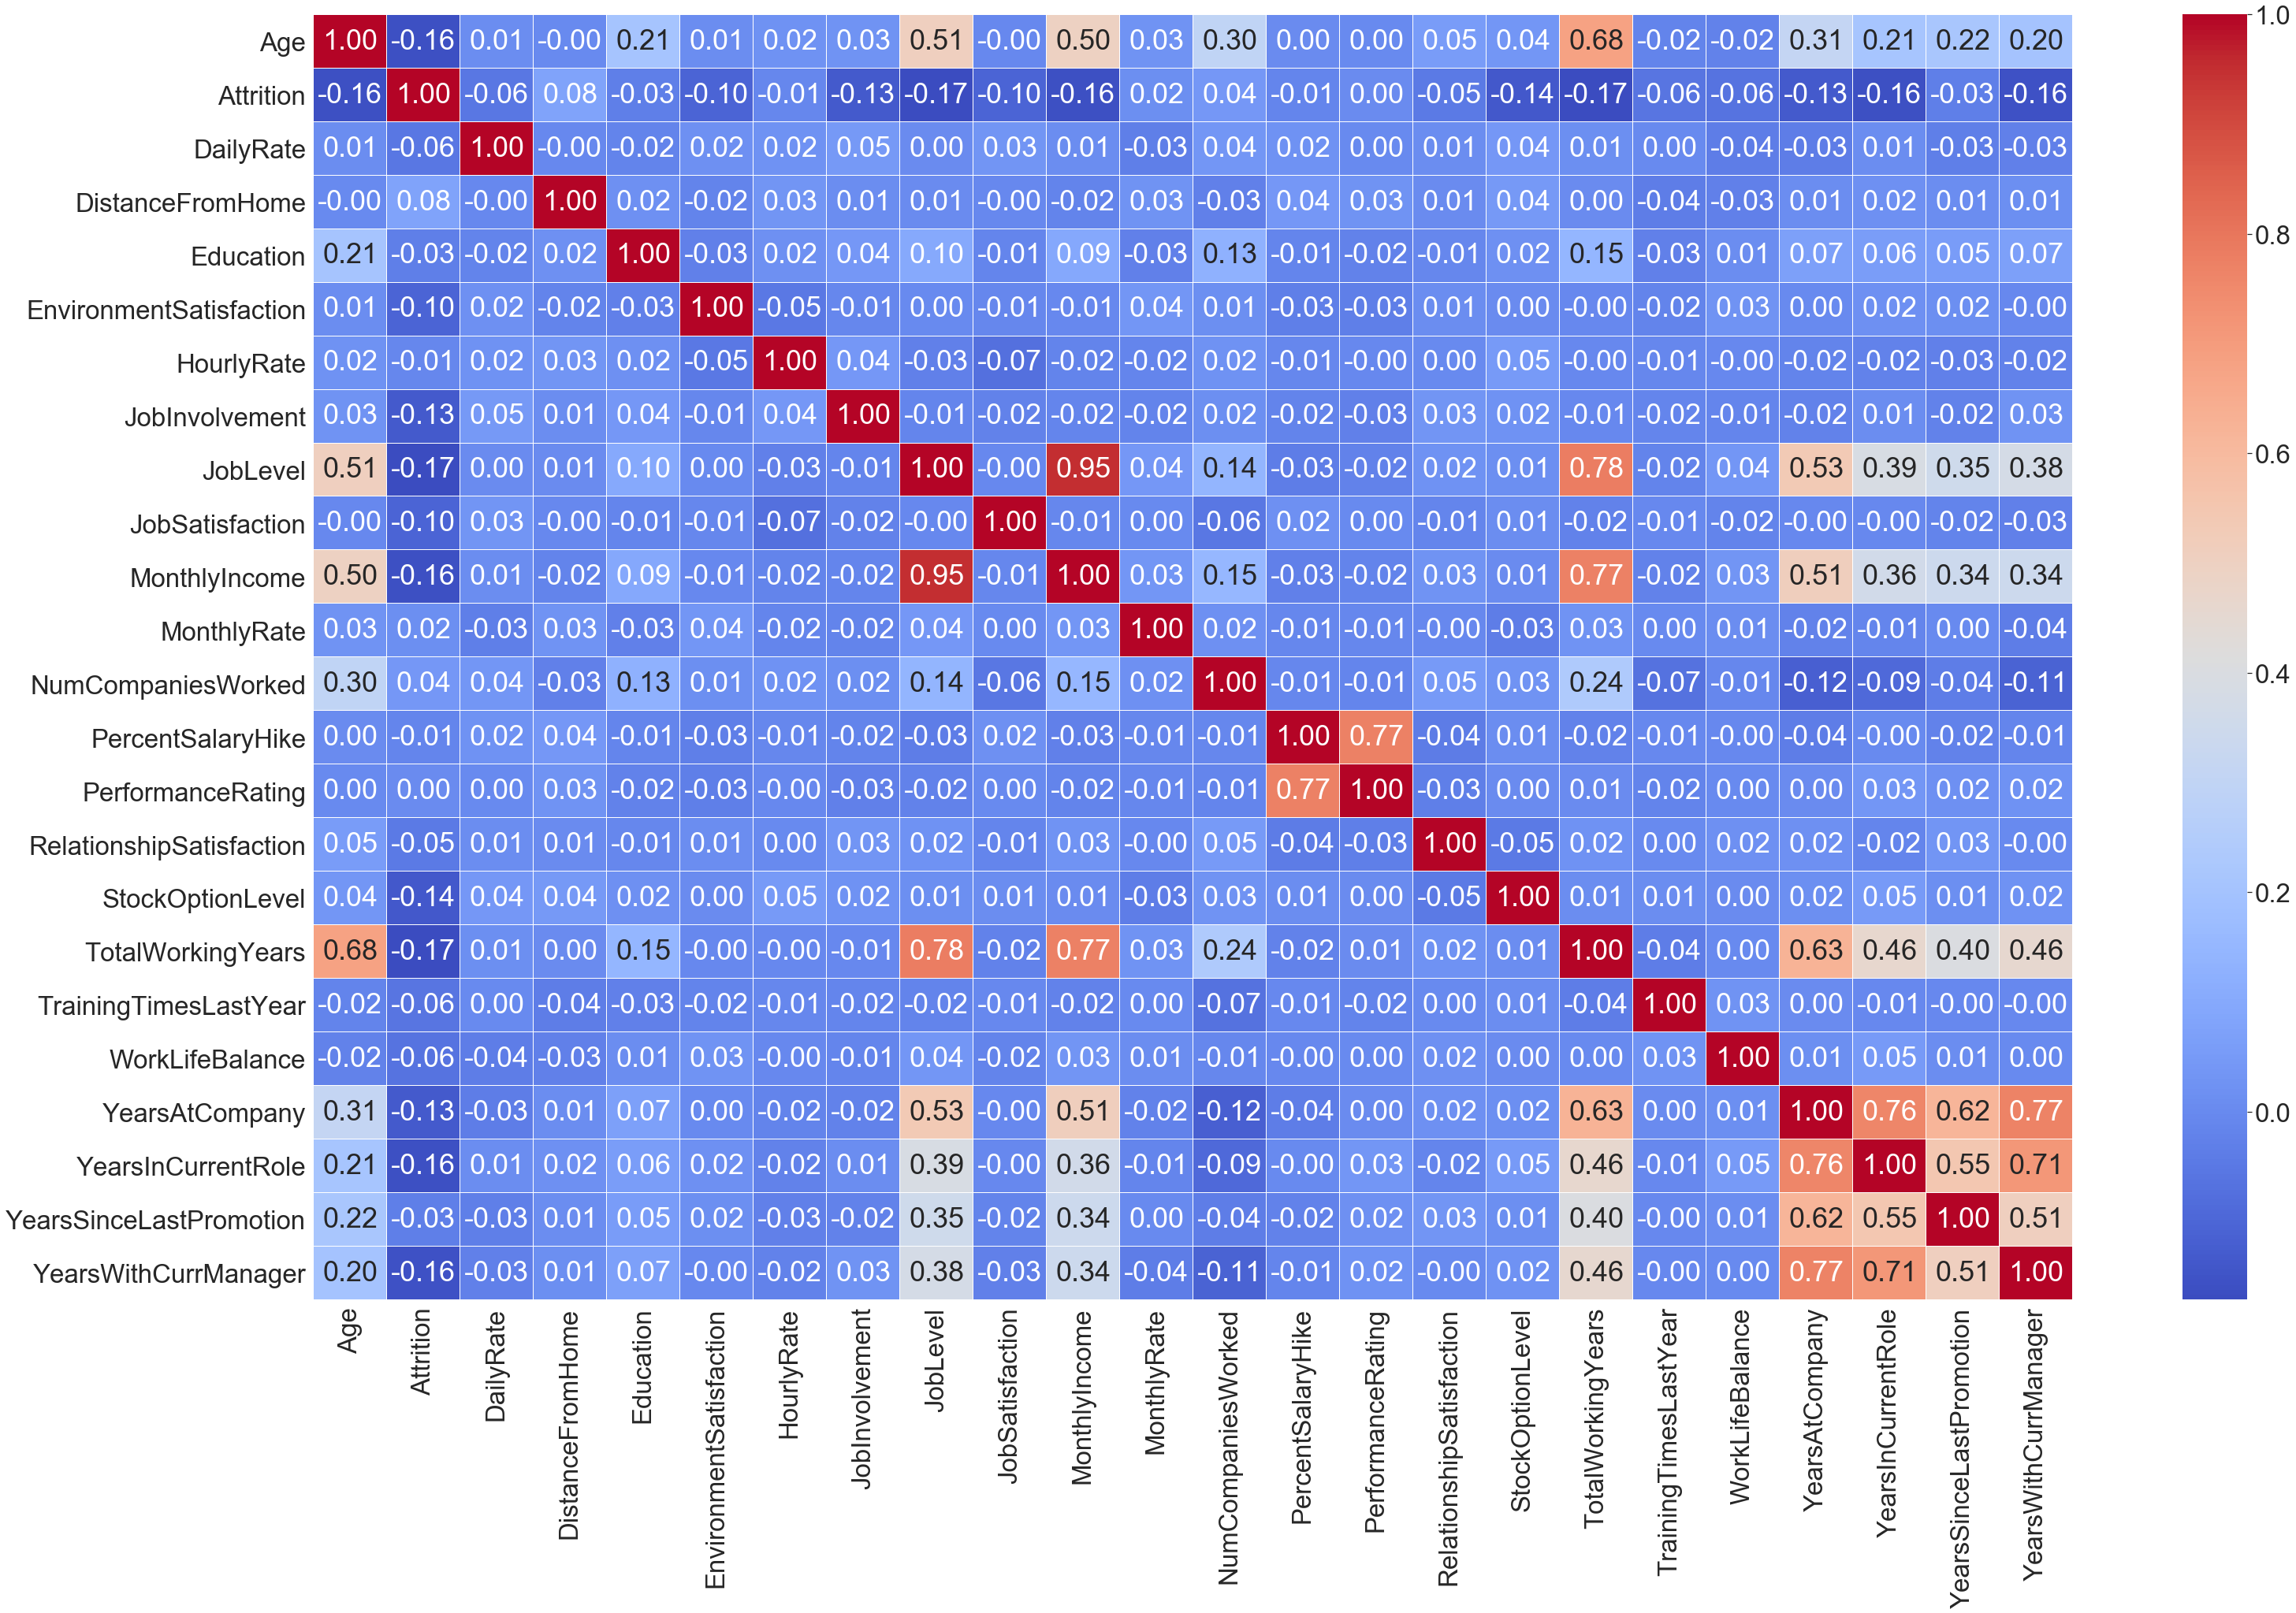

In [11]:
#Now lets move on to Numeric variables & study correlations
emp_data_corr=employee_data.corr()
plt.subplots(figsize=(50,30))
sns.heatmap(emp_data_corr,xticklabels=emp_data_corr.columns.values,
            yticklabels=emp_data_corr.columns.values,annot=True,cmap="coolwarm",fmt="0.2f",linewidth=0.01)

#Notes 
#MonthlyIncome & JobLevel show very high correlation with each other, can be removed; multicolinearity!!
#We will still be keeping both and use Regularization and/or Non-parametric methods
#We have already removed Over18 (1.0 correlation with Attrition)
#TotalWorkingYears, StockOptions, MonthlyIncome, Age show '-' Correlation with Attrition as expected
#An interesting observation here is that monthly income and YearsAtCompany are + correlated
#PerformanceRating has high impact on PercentSalaryHike

In [12]:
#Notes
#We will be using simple LabelEncoding and not still go with OneHotEncoding
#LabelEncoding without OneHotEncoding doest really work well with some Algorithms as they detect a trend
#However as initially we would use Tree based Algorithms so LabelEncoding would suffice
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
for column in categorical_columns:
    employee_data[column] = label.fit_transform(employee_data[column])
employee_data.info()

#Notes
#Everything is converted to Integers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null int8
BusinessTravel              1470 non-null int64
DailyRate                   1470 non-null int64
Department                  1470 non-null int64
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null int64
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null int64
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null int64
MonthlyIncome               1470 non-null int64
MonthlyRate                 1470 non-null int64
NumCompaniesWorked          14

In [13]:
#Partitionining the data in predictors & target
x = employee_data.drop('Attrition', axis=1)
y = employee_data["Attrition"]

In [14]:
#Train-Test split, as the data is less we would be using Cross Validation technique later
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [15]:
print("X_Train shape: ", x_train.shape)
print("Y_Train shape: ",y_train.shape)
print("X_Test shape: ", x_test.shape)
print("Y_Test shape: ", y_test.shape)

X_Train shape:  (1029, 30)
Y_Train shape:  (1029,)
X_Test shape:  (441, 30)
Y_Test shape:  (441,)


In [16]:
#Checking whether Data is well balanced between the 2 classes in both train/test
print ("\nValue counts for y_train:\n", y_train.value_counts())
print ("\nValue counts for y_test:\n", y_test.value_counts())


Value counts for y_train:
 0    853
1    176
Name: Attrition, dtype: int64

Value counts for y_test:
 0    380
1     61
Name: Attrition, dtype: int64


In [38]:
#Notes
#Utility (Model independent) functions for Accuracies & Feature importances

all_features=['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager']

def classification_accuracy_report(actual,predicted):
    print ("\nAccuracy Score on Test Data: ", accuracy_score(actual,predicted))
    print ("\nConfusion Matrix on Test Data:\n", confusion_matrix(actual,predicted))
    print ("\nClassification Report on Test Data:\n",classification_report(actual,predicted))

    
def features_rank(feature_importance_coefficients,index_labels):
    feature_importance_coefficients=map(abs,feature_importance_coefficients)
    feature_with_coeff=zip(feature_importance_coefficients,index_labels)
    data=list(feature_with_coeff)
    print ("\nFeatures and their importances:\n", data)
    #print (sorted(data, key=lambda x: x[1],reverse=True))
    #print (ranked_features)
    #print ("\nRanked Features:\n", [elem[1] for elem in ranked_features])

In [39]:
#Starting with plain vanilla decsion trees

print ("VANILLA DECISION TREES\n")

decision_tree=DecisionTreeClassifier()
scores=cross_val_score(decision_tree,x_train,y_train,cv=10)
print ("Cross Validation Scores on the training set: ", scores)

decision_tree=DecisionTreeClassifier(random_state=42).fit(x_train,y_train)
y_test_pred = decision_tree.predict(x_test)
classification_accuracy_report(y_test,y_test_pred)
print ("In the report above 0")

coeff_list=decision_tree.feature_importances_
features_rank(coeff_list,all_features)

VANILLA DECISION TREES

Cross Validation Scores on the training set:  [0.7961165  0.82524272 0.82524272 0.77669903 0.77669903 0.80582524
 0.7184466  0.74757282 0.7961165  0.71568627]

Accuracy Score on Test Data:  0.7777777777777778

Confusion Matrix on Test Data:
 [[323  57]
 [ 41  20]]

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87       380
           1       0.26      0.33      0.29        61

    accuracy                           0.78       441
   macro avg       0.57      0.59      0.58       441
weighted avg       0.80      0.78      0.79       441

In the report above 0

Features and their importances:
 [(0.08722849695650017, 'Age'), (0.007290517888503261, 'BusinessTravel'), (0.07118262608544246, 'DailyRate'), (0.012496709878277607, 'Department'), (0.04967502732640931, 'DistanceFromHome'), (0.029531647699845148, 'Education'), (0.028566729800705355, 'EducationField'), (0.01566663114142598,

In [49]:
print ("ENSEMBLE - BAGGING DECISION TREES WITHOUT OVERSAMPLING\n")

bagging_classsifier=BaggingClassifier(DecisionTreeClassifier(),n_estimators=30,bootstrap=True,random_state=42)

scores=cross_val_score(bagging_classsifier,x_train,y_train,cv=5)
print ("Cross Validation Scores on the training set: ", scores)

bagging_classsifier.fit(x_train,y_train)

coeff_list=np.mean([tree.feature_importances_ for tree in bagging_classsifier.estimators_],axis=0)

y_test_pred = bagging_classsifier.predict(x_test)
classification_accuracy_report(y_test,y_test_pred)

ENSEMBLE - BAGGING DECISION TREES WITHOUT OVERSAMPLING

Cross Validation Scores on the training set:  [0.84951456 0.8592233  0.85436893 0.82038835 0.86341463]

Accuracy Score on Test Data:  0.8639455782312925

Confusion Matrix on Test Data:
 [[371   9]
 [ 51  10]]

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       380
           1       0.53      0.16      0.25        61

    accuracy                           0.86       441
   macro avg       0.70      0.57      0.59       441
weighted avg       0.83      0.86      0.83       441



In [ ]:
#Notes

#We are getting poor results as we have not done oversampling
#Our target variable Attrition is highly imbalanced
#Lets use smote to oversample

In [41]:
oversampler=SMOTE(random_state=0)
smote_train, smote_target = oversampler.fit_sample(x_train,y_train)

In [42]:
smote_target.shape

(1706,)

In [50]:
print ("ENSEMBLE - BAGGING DECISION TREES WITH OVERSAMPLING\n")

bagging_classsifier=BaggingClassifier(DecisionTreeClassifier(),n_estimators=40,bootstrap=True,random_state=42)

scores=cross_val_score(bagging_classsifier,smote_train,smote_target,cv=10)
print ("Cross Validation Scores on the training set: ", scores)

bagging_classsifier.fit(smote_train,smote_target)

coeff_list=np.mean([tree.feature_importances_ for tree in bagging_classsifier.estimators_],axis=0)

y_test_pred = bagging_classsifier.predict(x_test)
classification_accuracy_report(y_test,y_test_pred)

ENSEMBLE - BAGGING DECISION TREES WITH OVERSAMPLING

Cross Validation Scores on the training set:  [0.78947368 0.70760234 0.9122807  0.93567251 0.92397661 0.95321637
 0.92352941 0.94705882 0.94117647 0.91176471]

Accuracy Score on Test Data:  0.8458049886621315

Confusion Matrix on Test Data:
 [[354  26]
 [ 42  19]]

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       380
           1       0.42      0.31      0.36        61

    accuracy                           0.85       441
   macro avg       0.66      0.62      0.64       441
weighted avg       0.83      0.85      0.84       441



In [52]:
print ("RANDOM FOREST WITHOUT OVERSAMPLING\n")

rf = RandomForestClassifier(n_estimators=10, max_depth=4, max_features='sqrt', random_state=42 )
scores=cross_val_score(rf,x_train,y_train,cv=10)
print ("Cross Validation Scores on the training set: ", scores)

rf.fit(x_train,y_train)

coeff_list=np.mean([tree.feature_importances_ for tree in rf.estimators_],axis=0)

y_test_pred = rf.predict(x_test)
classification_accuracy_report(y_test,y_test_pred)

RANDOM FOREST WITHOUT OVERSAMPLING

Cross Validation Scores on the training set:  [0.87378641 0.84466019 0.88349515 0.84466019 0.82524272 0.85436893
 0.82524272 0.83495146 0.82524272 0.85294118]

Accuracy Score on Test Data:  0.8684807256235828

Confusion Matrix on Test Data:
 [[378   2]
 [ 56   5]]

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.87      0.99      0.93       380
           1       0.71      0.08      0.15        61

    accuracy                           0.87       441
   macro avg       0.79      0.54      0.54       441
weighted avg       0.85      0.87      0.82       441



In [58]:
print ("RANDOM FOREST WITH OVERSAMPLING\n")

rf = RandomForestClassifier(n_estimators=10, max_depth=4, max_features='sqrt', random_state=42 )
scores=cross_val_score(rf,smote_train,smote_target,cv=10)
print ("Cross Validation Scores on the training set: ", scores)

rf.fit(smote_train,smote_target)

coeff_list=np.mean([tree.feature_importances_ for tree in rf.estimators_],axis=0)

y_test_pred = rf.predict(x_test)
classification_accuracy_report(y_test,y_test_pred)


RANDOM FOREST WITH OVERSAMPLING

Cross Validation Scores on the training set:  [0.74853801 0.70175439 0.84210526 0.8128655  0.8128655  0.86549708
 0.85294118 0.80588235 0.79411765 0.87058824]

Accuracy Score on Test Data:  0.7936507936507936

Confusion Matrix on Test Data:
 [[320  60]
 [ 31  30]]

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.91      0.84      0.88       380
           1       0.33      0.49      0.40        61

    accuracy                           0.79       441
   macro avg       0.62      0.67      0.64       441
weighted avg       0.83      0.79      0.81       441

